# Batfish Evaluation


In order to evaluate Batfish as a static solution against dynamic solutions such as P4Consist and Vermon, a series of evaluations must be performed to collect data.
As a first approximation, this evaluation will follow simple test cases to each test case specified in Vermon's performance evaluation.

This evaluation has as base this notebook [here](https://youtu.be/Yje70Q8R79w).


In [1]:
# Import packages and load questions
%run startup.py
load_questions()

import time

In this notebook we will use the network shown in the diagram below. You can view and download the device configuration files in the folder adjacent to this notebook.







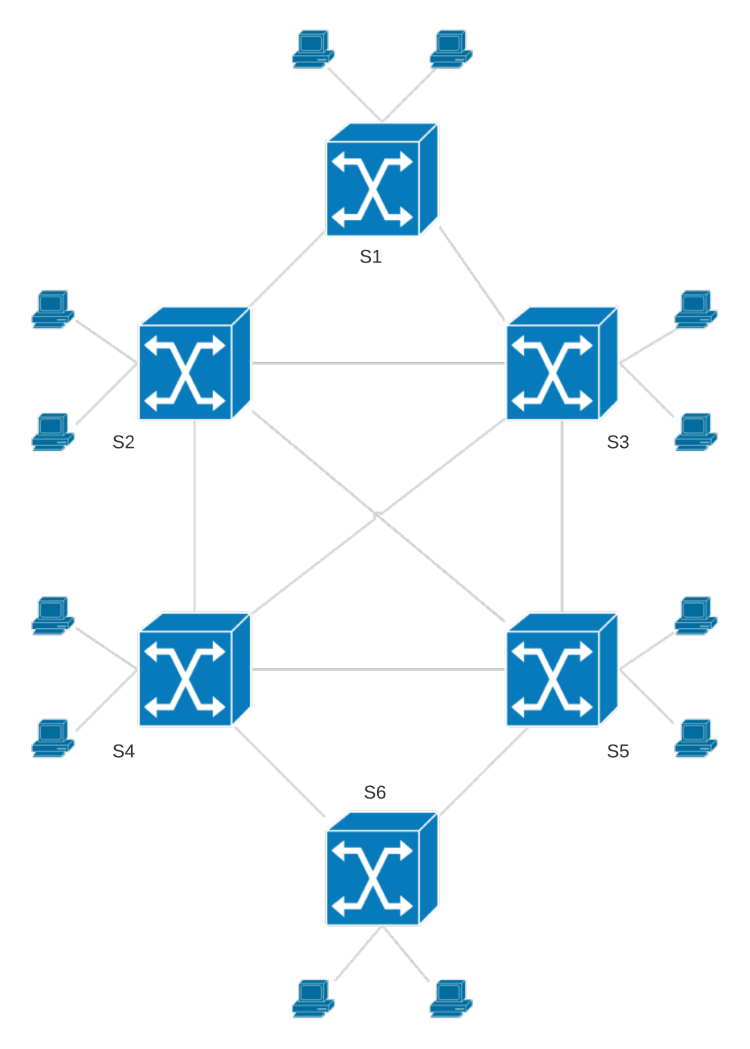

In [2]:
from IPython import display
display.Image("networks/batfish-evaluation/Network.png")

## Change Scenario 1: Base network

The network is overprovisioned with failover redundancy for the switches.There are 5 flows in the network (namely red, orange, green, black and purple). Each flow has its start and end node, as well as a predetermined path that they should take. Further detail of the path of each flow is presented below.

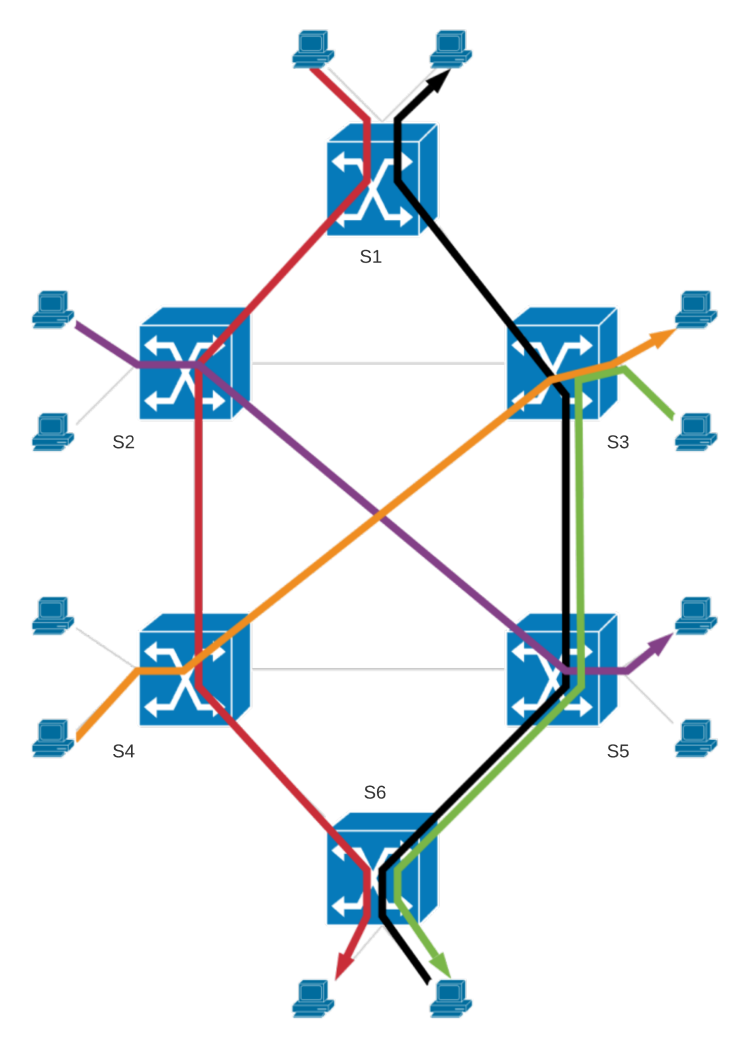

In [3]:
from IPython import display
display.Image("networks/batfish-evaluation/Expected Behavior.png")

### Step 1: Test current behavior


Before beginning, let's check that the network is working as expected. First we load our snapshot into Batfish.

In [4]:
NETWORK_NAME = "batfish-evaluation"
BASE_NAME = "base"
BASE_PATH = "networks/batfish-evaluation/base"

bf_set_network(NETWORK_NAME)
bf_init_snapshot(BASE_PATH, name=BASE_NAME, overwrite=True)

'base'

In [5]:
bfq.edges(nodes="sw3", edgeType="layer3").answer().frame()

,Interface,IPs,Remote_Interface,Remote_IPs
0,sw3[GigabitEthernet0/0],['2.10.11.2'],sw1[GigabitEthernet1/0],['2.10.11.1']
1,sw3[GigabitEthernet1/0],['2.10.12.2'],sw2[GigabitEthernet1/0],['2.10.12.1']
2,sw3[GigabitEthernet4/0],['2.31.10.1'],h_3_1[eth0],['2.31.10.2']
3,sw3[GigabitEthernet2/0],['2.10.15.1'],sw4[GigabitEthernet1/0],['2.10.15.2']
4,sw3[GigabitEthernet3/0],['2.10.16.1'],sw5[GigabitEthernet1/0],['2.10.16.2']


In [6]:
tr_frame = bfq.traceroute(startLocation="h_3_1", headers=HeaderConstraints(dstIps="h_6_1")).answer().frame()
show(tr_frame)

,Flow,Traces,TraceCount
0,Start Location: h_3_1Src IP: 2.31.10.2Src Port: 49152Dst IP: 2.61.10.2Dst Port: 33434IP Protocol: UDP,"ACCEPTED1. node: h_3_1 ORIGINATED(default) FORWARDED(ARP IP: 2.31.10.1, Output Interface: eth0, Routes: [static (Network: 0.0.0.0/0, Next Hop IP:2.31.10.1)]) TRANSMITTED(eth0)2. node: sw3 RECEIVED(GigabitEthernet4/0) FORWARDED(ARP IP: 2.10.16.2, Output Interface: GigabitEthernet3/0, Routes: [static (Network: 2.61.10.0/24, Next Hop IP:2.10.16.2)]) TRANSMITTED(GigabitEthernet3/0)3. node: sw5 RECEIVED(GigabitEthernet1/0) FORWARDED(ARP IP: 2.10.19.2, Output Interface: GigabitEthernet3/0, Routes: [static (Network: 2.61.10.0/24, Next Hop IP:2.10.19.2)]) TRANSMITTED(GigabitEthernet3/0)4. node: sw6 RECEIVED(GigabitEthernet1/0) FORWARDED(ARP IP: AUTO/NONE(-1l), Output Interface: GigabitEthernet2/0, Routes: [connected (Network: 2.61.10.0/24, Next Hop IP:AUTO/NONE(-1l))]) TRANSMITTED(GigabitEthernet2/0)5. node: h_6_1 RECEIVED(eth0) ACCEPTED(eth0)",1


Batfish will automatically compute the RIBs and FIBs from the configuration files in the snapshot, allowing us to test the forwarding behavior offline. Let's do a simple reachability test of a flow to check if the reachability is being maintened in this network. We will check the reachability of flow Orange.

In [7]:
path = PathConstraints()
headers = HeaderConstraints(srcIps="h_4_1", dstIps="h_3_1", ipProtocols="TCP")
reach = bfq.reachability(pathConstraints=path, headers=headers, actions="accepted").answer().frame()
show(reach)

,Flow,Traces,TraceCount
0,Start Location: h_3_1Src IP: 2.41.10.2Src Port: 49152Dst IP: 2.31.10.2Dst Port: 80IP Protocol: TCP,ACCEPTED1. node: h_3_1 ORIGINATED(default) ACCEPTED(eth0),1
1,Start Location: h_3_1 interface=eth0Src IP: 2.41.10.2Src Port: 49152Dst IP: 2.31.10.2Dst Port: 80IP Protocol: TCP,ACCEPTED1. node: h_3_1 RECEIVED(eth0) ACCEPTED(eth0),1
2,Start Location: h_4_1Src IP: 2.41.10.2Src Port: 49152Dst IP: 2.31.10.2Dst Port: 80IP Protocol: TCP,"ACCEPTED1. node: h_4_1 ORIGINATED(default) FORWARDED(ARP IP: 2.41.10.1, Output Interface: eth0, Routes: [static (Network: 0.0.0.0/0, Next Hop IP:2.41.10.1)]) TRANSMITTED(eth0)2. node: sw4 RECEIVED(GigabitEthernet4/0) FORWARDED(ARP IP: 2.10.15.1, Output Interface: GigabitEthernet1/0, Routes: [static (Network: 2.31.10.0/24, Next Hop IP:2.10.15.1)]) TRANSMITTED(GigabitEthernet1/0)3. node: sw3 RECEIVED(GigabitEthernet2/0) FORWARDED(ARP IP: AUTO/NONE(-1l), Output Interface: GigabitEthernet4/0, Routes: [connected (Network: 2.31.10.0/24, Next Hop IP:AUTO/NONE(-1l))]) TRANSMITTED(GigabitEthernet4/0)4. node: h_3_1 RECEIVED(eth0) ACCEPTED(eth0)",1
3,Start Location: h_4_1 interface=eth0Src IP: 2.41.10.2Src Port: 49152Dst IP: 2.31.10.2Dst Port: 80IP Protocol: TCP,"ACCEPTED1. node: h_4_1 RECEIVED(eth0) FORWARDED(ARP IP: 2.41.10.1, Output Interface: eth0, Routes: [static (Network: 0.0.0.0/0, Next Hop IP:2.41.10.1)]) TRANSMITTED(eth0)2. node: sw4 RECEIVED(GigabitEthernet4/0) FORWARDED(ARP IP: 2.10.15.1, Output Interface: GigabitEthernet1/0, Routes: [static (Network: 2.31.10.0/24, Next Hop IP:2.10.15.1)]) TRANSMITTED(GigabitEthernet1/0)3. node: sw3 RECEIVED(GigabitEthernet2/0) FORWARDED(ARP IP: AUTO/NONE(-1l), Output Interface: GigabitEthernet4/0, Routes: [connected (Network: 2.31.10.0/24, Next Hop IP:AUTO/NONE(-1l))]) TRANSMITTED(GigabitEthernet4/0)4. node: h_3_1 RECEIVED(eth0) ACCEPTED(eth0)",1
4,Start Location: sw3Src IP: 2.41.10.2Src Port: 49152Dst IP: 2.31.10.2Dst Port: 80IP Protocol: TCP,"ACCEPTED1. node: sw3 ORIGINATED(default) FORWARDED(ARP IP: AUTO/NONE(-1l), Output Interface: GigabitEthernet4/0, Routes: [connected (Network: 2.31.10.0/24, Next Hop IP:AUTO/NONE(-1l))]) TRANSMITTED(GigabitEthernet4/0)2. node: h_3_1 RECEIVED(eth0) ACCEPTED(eth0)",1
5,Start Location: sw3 interface=GigabitEthernet0/0Src IP: 2.41.10.2Src Port: 49152Dst IP: 2.31.10.2Dst Port: 80IP Protocol: TCP,"ACCEPTED1. node: sw3 RECEIVED(GigabitEthernet0/0) FORWARDED(ARP IP: AUTO/NONE(-1l), Output Interface: GigabitEthernet4/0, Routes: [connected (Network: 2.31.10.0/24, Next Hop IP:AUTO/NONE(-1l))]) TRANSMITTED(GigabitEthernet4/0)2. node: h_3_1 RECEIVED(eth0) ACCEPTED(eth0)",1
6,Start Location: sw3 interface=GigabitEthernet1/0Src IP: 2.41.10.2Src Port: 49152Dst IP: 2.31.10.2Dst Port: 80IP Protocol: TCP,"ACCEPTED1. node: sw3 RECEIVED(GigabitEthernet1/0) FORWARDED(ARP IP: AUTO/NONE(-1l), Output Interface: GigabitEthernet4/0, Routes: [connected (Network: 2.31.10.0/24, Next Hop IP:AUTO/NONE(-1l))]) TRANSMITTED(GigabitEthernet4/0)2. node: h_3_1 RECEIVED(eth0) ACCEPTED(eth0)",1
7,Start Location: sw3 interface=GigabitEthernet2/0Src IP: 2.41.10.2Src Port: 49152Dst IP: 2.31.10.2Dst Port: 80IP Protocol: TCP,"ACCEPTED1. node: sw3 RECEIVED(GigabitEthernet2/0) FORWARDED(ARP IP: AUTO/NONE(-1l), Output Interface: GigabitEthernet4/0, Routes: [connected (Network: 2.31.10.0/24, Next Hop IP:AUTO/NONE(-1l))]) TRANSMITTED(GigabitEthernet4/0)2. node: h_3_1 RECEIVED(eth0) ACCEPTED(eth0)",1
8,Start Location: sw3 interface=GigabitEthernet3/0Src IP: 2.41.10.2Src Port: 49152Dst IP: 2.31.10.2Dst Port: 80IP Protocol: TCP,"ACCEPTED1. node: sw3 RECEIVED(GigabitEthernet3/0) FORWARDED(ARP IP: AUTO/NONE(-1l), Output Interface: GigabitEthernet4/0, Routes: [connected (Network: 2.31.10.0/24, Next Hop IP:AUTO/NONE(-1l))]) TRANSMITTED(GigabitEthernet4/0)2. node: h_3_1 RECEIVED(eth0) ACCEPTED(eth0)",1
9,Start Location: sw3 interface=GigabitEthernet4/0Src IP: 2.41.10.2Src Port: 49152Dst IP: 2.31.10.2Dst Port: 80IP Protocol: TCP,"ACCEPTED1. node: sw3 RECEIVED(Gi

This result shows that we have reachability end to end in the network for flow Orange.

Next, we'll cost change the routing behavior of most of the switches in the network, making some destinations unavailable or changing the course of path of our flows. Each change will be displayed below for each test case with its respecting time used to execute the query.


## Step 2: Modifying the behavior of the network 


The following commands will load our change snapshot into batfish:


In [8]:
CHANGE1_NAME = "change"
CHANGE1_PATH = "networks/batfish-evaluation/change1"

bf_init_snapshot(CHANGE1_PATH, name=CHANGE1_NAME, overwrite=True)

'change'

With these comands, we loaded a new snapshot inside our program. Now we are able to evaluate the performance of batfish in scenarios with misconfigurations leading to errors inside our network.

The new behavior of the flows inside the network is shown below.

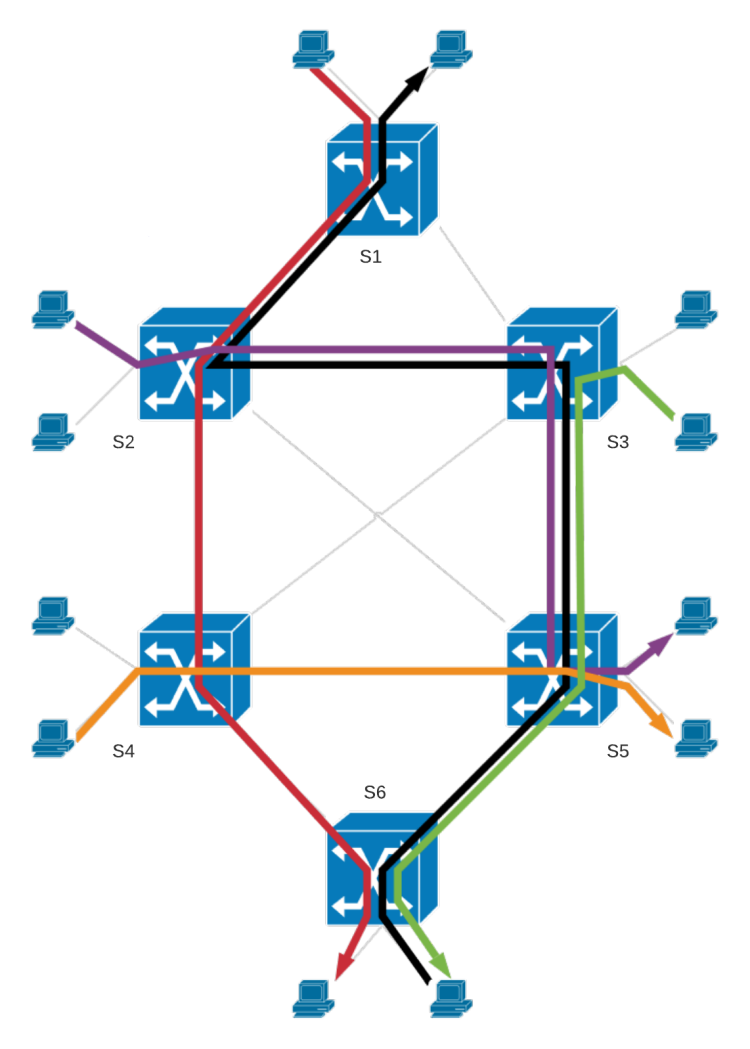

In [9]:
from IPython import display
display.Image("networks/batfish-evaluation/Modified Behavior 1.png")

Great!! Now, for each test case in Vermon's performance evaluation, we will be executing an equivalent query below.

Each query is displayed separately, explaining each case.


### Reachability Test

For the reachability test, we will be querying orange flow, who should start in S4 and reach S3. 

In [10]:
start = time.time()
answer = bfq.reachability(
    pathConstraints=PathConstraints(
        startLocation="h_4_1"),
    headers=HeaderConstraints(dstIps="h_3_1"),
    actions="SUCCESS,FAILURE"
).answer(snapshot=CHANGE1_NAME)
show(answer.frame())
end = time.time()
reachability_time = end - start

,Flow,Traces,TraceCount
0,Start Location: h_4_1Src IP: 2.41.10.2Dst IP: 2.31.10.2IP Protocol: ICMP,"LOOP1. node: h_4_1 ORIGINATED(default) FORWARDED(ARP IP: 2.41.10.1, Output Interface: eth0, Routes: [static (Network: 0.0.0.0/0, Next Hop IP:2.41.10.1)]) TRANSMITTED(eth0)2. node: sw4 RECEIVED(GigabitEthernet4/0) FORWARDED(ARP IP: 2.10.17.2, Output Interface: GigabitEthernet2/0, Routes: [static (Network: 2.31.10.0/24, Next Hop IP:2.10.17.2)]) TRANSMITTED(GigabitEthernet2/0)3. node: sw5 RECEIVED(GigabitEthernet2/0) FORWARDED(ARP IP: 2.51.10.2, Output Interface: GigabitEthernet4/0, Routes: [static (Network: 2.31.10.0/24, Next Hop IP:2.51.10.2)]) TRANSMITTED(GigabitEthernet4/0)4. node: h_5_1 RECEIVED(eth0) FORWARDED(ARP IP: 2.51.10.1, Output Interface: eth0, Routes: [static (Network: 0.0.0.0/0, Next Hop IP:2.51.10.1)]) TRANSMITTED(eth0)5. node: sw5 RECEIVED(GigabitEthernet4/0) FORWARDED(ARP IP: 2.51.10.2, Output Interface: GigabitEthernet4/0, Routes: [static (Network: 2.31.10.0/24, Next Hop IP:2.51.10.2)]) TRANSMITTED(GigabitEthernet4/0)6. node: h_5_1 RECEIVED(eth0) LOOP",1


As expected, Batfish was able to find the reachability error due to misconfigurations.



### Waypoint Test

For the waypoint test, we will be querying black flow, who should have a waypoint in S4. 

In [11]:
start = time.time()
answer = bfq.reachability(
    pathConstraints=PathConstraints(
        startLocation="h_6_1",
        transitLocations ="sw4"),
    headers=HeaderConstraints(dstIps="h_1_1"),
    actions="SUCCESS,FAILURE"
).answer(snapshot=CHANGE1_NAME)
show(answer.frame())
end = time.time()
waypoint_time = end - start

,Flow,Traces,TraceCount


As expected, Batfish was not able to find the a single trace that matched the description of a flow going from S6 to S1 with a waypoint in S4.



### Equal Path Length

For the path length test, we will be querying purple flow, who should have its length as 4 (H2, S2, S5, H5). 

In [12]:
start = time.time()
answer = bfq.reachability(
    pathConstraints=PathConstraints(
        startLocation="h_2_1",),
    headers=HeaderConstraints(dstIps="h_5_1"),
    actions="SUCCESS,FAILURE"
).answer(snapshot=CHANGE1_NAME)
show(answer.frame())
print("Trace Length: "+ str(len(answer['answerElements'][0]['rows'][0]['Traces'][0]['hops'])))
print("Expected Trace Length: 4")
end = time.time()
path_length_time = end - start

,Flow,Traces,TraceCount
0,Start Location: h_2_1Src IP: 2.21.10.2Dst IP: 2.51.10.2IP Protocol: ICMP,"ACCEPTED1. node: h_2_1 ORIGINATED(default) FORWARDED(ARP IP: 2.21.10.1, Output Interface: eth0, Routes: [static (Network: 0.0.0.0/0, Next Hop IP:2.21.10.1)]) TRANSMITTED(eth0)2. node: sw2 RECEIVED(GigabitEthernet4/0) FORWARDED(ARP IP: 2.10.12.2, Output Interface: GigabitEthernet1/0, Routes: [static (Network: 2.51.10.0/24, Next Hop IP:2.10.12.2)]) TRANSMITTED(GigabitEthernet1/0)3. node: sw3 RECEIVED(GigabitEthernet1/0) FORWARDED(ARP IP: 2.10.16.2, Output Interface: GigabitEthernet3/0, Routes: [static (Network: 2.51.10.0/24, Next Hop IP:2.10.16.2)]) TRANSMITTED(GigabitEthernet3/0)4. node: sw5 RECEIVED(GigabitEthernet1/0) FORWARDED(ARP IP: AUTO/NONE(-1l), Output Interface: GigabitEthernet4/0, Routes: [connected (Network: 2.51.10.0/24, Next Hop IP:AUTO/NONE(-1l))]) TRANSMITTED(GigabitEthernet4/0)5. node: h_5_1 RECEIVED(eth0) ACCEPTED(eth0)",1


Trace Length: 5
Expected Trace Length: 4


As expected, Batfish was able to detect the length of the path, and with its data we are able to detect that the length of the path is not what was expected.



### Disjoint Paths

For the Disjoint Paths test, we will be querying both Red and Black flows, who should have only two switches in common. 

In [13]:
start = time.time()
answer = bfq.reachability(
    pathConstraints=PathConstraints(
        startLocation="h_1_1",),
    headers=HeaderConstraints(dstIps="h_6_1"),
    actions="SUCCESS,FAILURE"
).answer(snapshot=CHANGE1_NAME)
show(answer.frame())

nd1 = []
for b in answer['answerElements'][0]['rows'][0]['Traces'][0]['hops']:
    nd1.append(b['node']['name'])

answer = bfq.reachability(
    pathConstraints=PathConstraints(
        startLocation="h_6_1",),
    headers=HeaderConstraints(dstIps="h_1_1"),
    actions="SUCCESS,FAILURE"
).answer(snapshot=CHANGE1_NAME)
show(answer.frame())

nd2 = []
for b in answer['answerElements'][0]['rows'][0]['Traces'][0]['hops']:
    nd2.append(b['node']['name'])

list1_as_set = set(nd1)

intersection = list1_as_set.intersection(nd2)

intersection_as_list = list(intersection)

leng = len(intersection_as_list) - 2

print("Expected amount of common switches: 2")
print("Amount of common switches: "+str(leng))
end = time.time()
disjoint_time = end - start


,Flow,Traces,TraceCount
0,Start Location: h_1_1Src IP: 2.11.10.2Dst IP: 2.61.10.2IP Protocol: ICMP,"ACCEPTED1. node: h_1_1 ORIGINATED(default) FORWARDED(ARP IP: 2.11.10.1, Output Interface: eth0, Routes: [static (Network: 0.0.0.0/0, Next Hop IP:2.11.10.1)]) TRANSMITTED(eth0)2. node: sw1 RECEIVED(GigabitEthernet2/0) FORWARDED(ARP IP: 2.10.10.2, Output Interface: GigabitEthernet0/0, Routes: [static (Network: 2.61.10.0/24, Next Hop IP:2.10.10.2)]) TRANSMITTED(GigabitEthernet0/0)3. node: sw2 RECEIVED(GigabitEthernet0/0) FORWARDED(ARP IP: 2.10.13.2, Output Interface: GigabitEthernet2/0, Routes: [static (Network: 2.61.10.0/24, Next Hop IP:2.10.13.2)]) TRANSMITTED(GigabitEthernet2/0)4. node: sw4 RECEIVED(GigabitEthernet0/0) FORWARDED(ARP IP: 2.10.18.2, Output Interface: GigabitEthernet3/0, Routes: [static (Network: 2.61.10.0/24, Next Hop IP:2.10.18.2)]) TRANSMITTED(GigabitEthernet3/0)5. node: sw6 RECEIVED(GigabitEthernet0/0) FORWARDED(ARP IP: AUTO/NONE(-1l), Output Interface: GigabitEthernet2/0, Routes: [connected (Network: 2.61.10.0/24, Next Hop IP:AUTO/NONE(-1l))]) TRANSMITTED(GigabitEthernet2/0)6. node: h_6_1 RECEIVED(eth0) ACCEPTED(eth0)",1


,Flow,Traces,TraceCount
0,Start Location: h_6_1Src IP: 2.61.10.2Dst IP: 2.11.10.2IP Protocol: ICMP,"ACCEPTED1. node: h_6_1 ORIGINATED(default) FORWARDED(ARP IP: 2.61.10.1, Output Interface: eth0, Routes: [static (Network: 0.0.0.0/0, Next Hop IP:2.61.10.1)]) TRANSMITTED(eth0)2. node: sw6 RECEIVED(GigabitEthernet2/0) FORWARDED(ARP IP: 2.10.19.1, Output Interface: GigabitEthernet1/0, Routes: [static (Network: 2.11.10.0/24, Next Hop IP:2.10.19.1)]) TRANSMITTED(GigabitEthernet1/0)3. node: sw5 RECEIVED(GigabitEthernet3/0) FORWARDED(ARP IP: 2.10.16.1, Output Interface: GigabitEthernet1/0, Routes: [static (Network: 2.11.10.0/24, Next Hop IP:2.10.16.1)]) TRANSMITTED(GigabitEthernet1/0)4. node: sw3 RECEIVED(GigabitEthernet3/0) FORWARDED(ARP IP: 2.10.12.1, Output Interface: GigabitEthernet1/0, Routes: [static (Network: 2.11.10.0/24, Next Hop IP:2.10.12.1)]) TRANSMITTED(GigabitEthernet1/0)5. node: sw2 RECEIVED(GigabitEthernet1/0) FORWARDED(ARP IP: 2.10.10.1, Output Interface: GigabitEthernet0/0, Routes: [static (Network: 2.11.10.0/24, Next Hop IP:2.10.10.1)]) TRANSMITTED(GigabitEthernet0/0)6. node: sw1 RECEIVED(GigabitEthernet0/0) FORWARDED(ARP IP: AUTO/NONE(-1l), Output Interface: GigabitEthernet2/0, Routes: [connected (Network: 2.11.10.0/24, Next Hop IP:AUTO/NONE(-1l))]) TRANSMITTED(GigabitEthernet2/0)7. node: h_1_1 RECEIVED(eth0) ACCEPTED(eth0)",1


Expected amount of common switches: 2
Amount of common switches: 3


As expected, Batfish was able to detect the amount of common switches, and we are able to check that the value is not what was expected.



### Path Preference

For the path preference test, we will be querying black flow, who should have its length as 6 (H6, S6, S5, S3, S1, H1). 

In [14]:
start = time.time()
answer = bfq.reachability(
    pathConstraints=PathConstraints(
        startLocation="h_6_1",),
    headers=HeaderConstraints(dstIps="h_1_1"),
    actions="SUCCESS,FAILURE"
).answer(snapshot=CHANGE1_NAME)
show(answer.frame())
print("Path Length: "+ str(len(answer['answerElements'][0]['rows'][0]['Traces'][0]['hops'])))
print("Expected Path Length: 6")
end = time.time()
path_preference_time = end - start

,Flow,Traces,TraceCount
0,Start Location: h_6_1Src IP: 2.61.10.2Dst IP: 2.11.10.2IP Protocol: ICMP,"ACCEPTED1. node: h_6_1 ORIGINATED(default) FORWARDED(ARP IP: 2.61.10.1, Output Interface: eth0, Routes: [static (Network: 0.0.0.0/0, Next Hop IP:2.61.10.1)]) TRANSMITTED(eth0)2. node: sw6 RECEIVED(GigabitEthernet2/0) FORWARDED(ARP IP: 2.10.19.1, Output Interface: GigabitEthernet1/0, Routes: [static (Network: 2.11.10.0/24, Next Hop IP:2.10.19.1)]) TRANSMITTED(GigabitEthernet1/0)3. node: sw5 RECEIVED(GigabitEthernet3/0) FORWARDED(ARP IP: 2.10.16.1, Output Interface: GigabitEthernet1/0, Routes: [static (Network: 2.11.10.0/24, Next Hop IP:2.10.16.1)]) TRANSMITTED(GigabitEthernet1/0)4. node: sw3 RECEIVED(GigabitEthernet3/0) FORWARDED(ARP IP: 2.10.12.1, Output Interface: GigabitEthernet1/0, Routes: [static (Network: 2.11.10.0/24, Next Hop IP:2.10.12.1)]) TRANSMITTED(GigabitEthernet1/0)5. node: sw2 RECEIVED(GigabitEthernet1/0) FORWARDED(ARP IP: 2.10.10.1, Output Interface: GigabitEthernet0/0, Routes: [static (Network: 2.11.10.0/24, Next Hop IP:2.10.10.1)]) TRANSMITTED(GigabitEthernet0/0)6. node: sw1 RECEIVED(GigabitEthernet0/0) FORWARDED(ARP IP: AUTO/NONE(-1l), Output Interface: GigabitEthernet2/0, Routes: [connected (Network: 2.11.10.0/24, Next Hop IP:AUTO/NONE(-1l))]) TRANSMITTED(GigabitEthernet2/0)7. node: h_1_1 RECEIVED(eth0) ACCEPTED(eth0)",1


Path Length: 7
Expected Path Length: 6


As expected, Batfish was able to detect the length of the path, and with its possible to check that the path taken by the flow is not what was expected.



## Modifying the behavior of the network to generate loops and black holes


To further analyze the extent of Batfish's, we need to generate scenarios where loops and black holes are present. For this, some forwarding rules were modified, and the new expected behavior of the network is shown in the picture below.

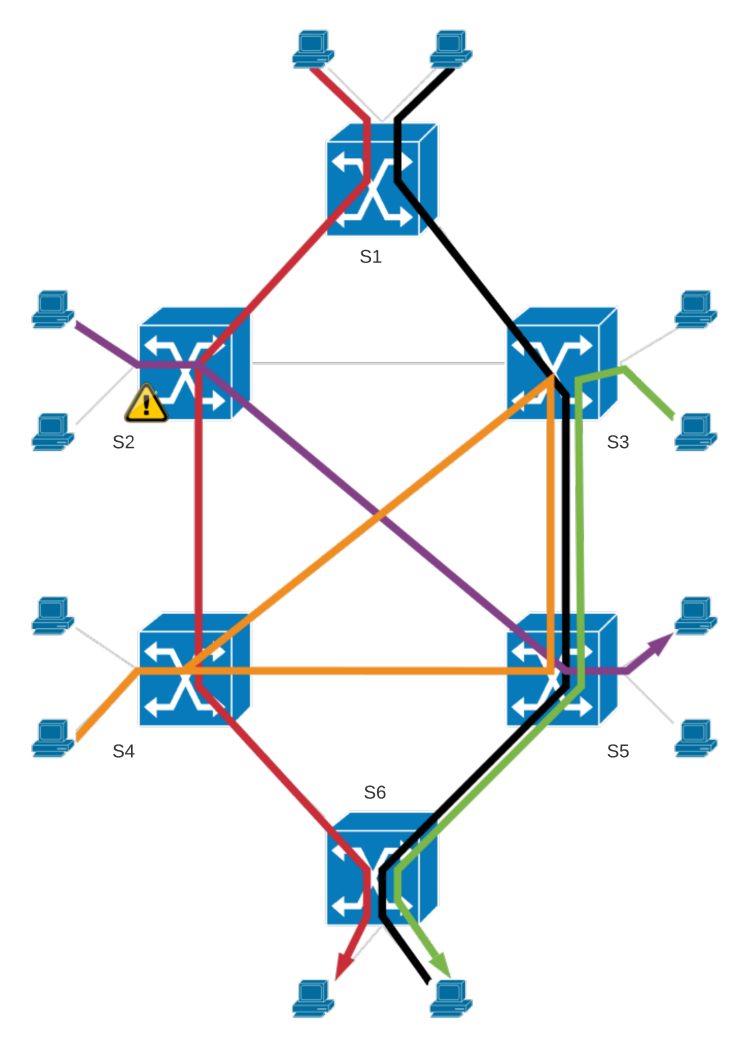

In [15]:
from IPython import display
display.Image("networks/batfish-evaluation/Modified Behavior 2.png")

The following commands will load our change snapshot into batfish:


In [16]:
CHANGE2_NAME = "change"
CHANGE2_PATH = "networks/batfish-evaluation/change2"

bf_init_snapshot(CHANGE2_PATH, name=CHANGE2_NAME, overwrite=True)

'change'

### Loop Freedom Test

For the Loop Freedom test, we will be querying orange flow, who should start in S4 and reach S3. 

In [17]:
start = time.time()
answer = bfq.reachability(
    pathConstraints=PathConstraints(
        startLocation="h_4_1",),
    headers=HeaderConstraints(dstIps="h_3_1"),
    actions="SUCCESS,FAILURE"
).answer(snapshot=CHANGE2_NAME)
show(answer.frame())
end = time.time()
loop_time = end - start

,Flow,Traces,TraceCount
0,Start Location: h_4_1Src IP: 2.41.10.2Dst IP: 2.31.10.2IP Protocol: ICMP,"LOOP1. node: h_4_1 ORIGINATED(default) FORWARDED(ARP IP: 2.41.10.1, Output Interface: eth0, Routes: [static (Network: 0.0.0.0/0, Next Hop IP:2.41.10.1)]) TRANSMITTED(eth0)2. node: sw4 RECEIVED(GigabitEthernet4/0) FORWARDED(ARP IP: 2.10.17.2, Output Interface: GigabitEthernet2/0, Routes: [static (Network: 2.31.10.0/24, Next Hop IP:2.10.17.2)]) TRANSMITTED(GigabitEthernet2/0)3. node: sw5 RECEIVED(GigabitEthernet2/0) FORWARDED(ARP IP: 2.10.16.1, Output Interface: GigabitEthernet1/0, Routes: [static (Network: 2.31.10.0/24, Next Hop IP:2.10.16.1)]) TRANSMITTED(GigabitEthernet1/0)4. node: sw3 RECEIVED(GigabitEthernet3/0) FORWARDED(ARP IP: 2.10.15.2, Output Interface: GigabitEthernet2/0, Routes: [static (Network: 2.31.10.2/32, Next Hop IP:2.10.15.2)]) TRANSMITTED(GigabitEthernet2/0)5. node: sw4 RECEIVED(GigabitEthernet1/0) FORWARDED(ARP IP: 2.10.17.2, Output Interface: GigabitEthernet2/0, Routes: [static (Network: 2.31.10.0/24, Next Hop IP:2.10.17.2)]) TRANSMITTED(GigabitEthernet2/0)6. node: sw5 RECEIVED(GigabitEthernet2/0) LOOP",1


As expected, Batfish was able to find the Loop generated in the network due to misconfigurations.



### Black Hole Freedom Test

For the Black Hole Freedom test, we will be querying red flow, who should be able to reach its destination. 

In [18]:
start = time.time()
answer = bfq.reachability(
    pathConstraints=PathConstraints(
        startLocation="h_1_1",),
    headers=HeaderConstraints(dstIps="h_6_1"),
    actions="SUCCESS,FAILURE"
).answer(snapshot=CHANGE2_NAME)
show(answer.frame())
end = time.time()
black_hole_time = end - start

,Flow,Traces,TraceCount
0,Start Location: h_1_1Src IP: 2.11.10.2Dst IP: 2.61.10.2IP Protocol: ICMP,"NO_ROUTE1. node: h_1_1 ORIGINATED(default) FORWARDED(ARP IP: 2.11.10.1, Output Interface: eth0, Routes: [static (Network: 0.0.0.0/0, Next Hop IP:2.11.10.1)]) TRANSMITTED(eth0)2. node: sw1 RECEIVED(GigabitEthernet2/0) FORWARDED(ARP IP: 2.10.10.2, Output Interface: GigabitEthernet0/0, Routes: [static (Network: 2.61.10.0/24, Next Hop IP:2.10.10.2)]) TRANSMITTED(GigabitEthernet0/0)3. node: sw2 RECEIVED(GigabitEthernet0/0) NO_ROUTE",1


As expected, Batfish was able to find that S2 has no routes for any given flow in the network.



# Final Results

Now, for each of the properties analyzed, a time was used to execute. The collection of the times required by each property is described below.

In [19]:
print("Property: Time used(ms)")
print("Rechability: "+str((round(reachability_time*1000))) +"ms")
print("Waypoint: "+str((round(waypoint_time*1000))) +"ms")
print("Equal Path Length: "+str((round(path_length_time*1000))) +"ms")
print("Disjoint Paths: "+str((round(disjoint_time*1000))) +"ms")
print("Path Preference: "+str((round(path_preference_time*1000))) +"ms")
print("Loop Freedom: "+str((round(loop_time*1000))) +"ms")
print("Black Hole Freedom: "+str((round(black_hole_time*1000))) +"ms")


Property: Time used(ms)
Rechability: 361ms
Waypoint: 388ms
Equal Path Length: 182ms
Disjoint Paths: 526ms
Path Preference: 187ms
Loop Freedom: 359ms
Black Hole Freedom: 187ms
